# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [18]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    cfg = [48, (96,2), 96, 192, 192, (384,2), 384, 384, 384, 384, 384,768,768]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(768, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [19]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [20]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [21]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [22]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [23]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [ ]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.320540, Accuracy: 10.94
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.280775, Accuracy: 14.84
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.126061, Accuracy: 20.70
Train Epoch: 0 [7680/50000 (17%)]	Loss: 1.926232, Accuracy: 24.80
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.914714, Accuracy: 26.76
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.835051, Accuracy: 31.05
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.837966, Accuracy: 29.69
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.793274, Accuracy: 33.40
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.700804, Accuracy: 36.33
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.689474, Accuracy: 38.09
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.707492, Accuracy: 34.57
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.652916, Accuracy: 34.18
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.667323, Accuracy: 35.74
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.670337, Accuracy: 35.35
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.587429, Accuracy: 40.43
Trai

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.668533, Accuracy: 75.59
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.663161, Accuracy: 77.93
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.607729, Accuracy: 78.91
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.591236, Accuracy: 79.49
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.635040, Accuracy: 77.73
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.614128, Accuracy: 79.10
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.611652, Accuracy: 77.73
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.664279, Accuracy: 75.39
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.563895, Accuracy: 79.10
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.562376, Accuracy: 80.66
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.578421, Accuracy: 78.52
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.575584, Accuracy: 79.10
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.616315, Accuracy: 77.15

Validation set: Average loss: 0.8642, Accuracy: 3606/5000 (72.00%)

the time of this epoch:[26.16749358177185 s]
Train Epoch: 7 

Train Epoch: 12 [23040/50000 (51%)]	Loss: 0.433716, Accuracy: 84.57
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.426053, Accuracy: 85.55
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.384438, Accuracy: 86.13
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.411371, Accuracy: 85.35
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.374838, Accuracy: 87.89
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.453261, Accuracy: 85.55
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.389578, Accuracy: 85.55
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.406190, Accuracy: 86.13
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.412077, Accuracy: 87.11

Validation set: Average loss: 0.5482, Accuracy: 4062/5000 (81.00%)

the time of this epoch:[26.086731433868408 s]

Test set: Average loss: 0.5517, Accuracy: 8206/10000 (82.06%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.348192, Accuracy: 88.67
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.371063, Accuracy: 87.30
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.423601, Accuracy: 85.74
Train Epoch: 

Train Epoch: 18 [25600/50000 (57%)]	Loss: 0.339683, Accuracy: 87.11
Train Epoch: 18 [28160/50000 (62%)]	Loss: 0.303571, Accuracy: 89.26
Train Epoch: 18 [30720/50000 (68%)]	Loss: 0.336795, Accuracy: 88.48
Train Epoch: 18 [33280/50000 (74%)]	Loss: 0.330799, Accuracy: 89.26
Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.313879, Accuracy: 89.06
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.361262, Accuracy: 88.28
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.382246, Accuracy: 89.26
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.289037, Accuracy: 87.89

Validation set: Average loss: 0.6454, Accuracy: 3946/5000 (78.00%)

the time of this epoch:[26.100104331970215 s]

Test set: Average loss: 0.6682, Accuracy: 7892/10000 (78.92%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.329498, Accuracy: 88.87
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.352383, Accuracy: 87.89
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.333722, Accuracy: 88.28
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.348966, Accuracy: 88.09
Train Epoch: 1

Train Epoch: 24 [28160/50000 (62%)]	Loss: 0.289761, Accuracy: 89.45
Train Epoch: 24 [30720/50000 (68%)]	Loss: 0.329044, Accuracy: 89.06
Train Epoch: 24 [33280/50000 (74%)]	Loss: 0.284844, Accuracy: 89.84
Train Epoch: 24 [35840/50000 (80%)]	Loss: 0.330215, Accuracy: 89.45
Train Epoch: 24 [38400/50000 (85%)]	Loss: 0.345916, Accuracy: 89.45
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.249509, Accuracy: 91.99
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.363359, Accuracy: 87.30

Validation set: Average loss: 0.5120, Accuracy: 4155/5000 (83.00%)

the time of this epoch:[26.011828422546387 s]

Test set: Average loss: 0.5123, Accuracy: 8338/10000 (83.38%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.317702, Accuracy: 89.45
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.247908, Accuracy: 91.41
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.260408, Accuracy: 91.02
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.251280, Accuracy: 91.80
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.241497, Accuracy: 91.80
Train Epoch: 2

Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.323584, Accuracy: 88.09
Train Epoch: 30 [33280/50000 (74%)]	Loss: 0.312949, Accuracy: 87.89
Train Epoch: 30 [35840/50000 (80%)]	Loss: 0.319275, Accuracy: 89.26
Train Epoch: 30 [38400/50000 (85%)]	Loss: 0.279250, Accuracy: 90.23
Train Epoch: 30 [40960/50000 (91%)]	Loss: 0.256239, Accuracy: 92.58
Train Epoch: 30 [43520/50000 (97%)]	Loss: 0.288439, Accuracy: 90.62

Validation set: Average loss: 0.8114, Accuracy: 3838/5000 (76.00%)

the time of this epoch:[26.074071407318115 s]

Test set: Average loss: 0.8225, Accuracy: 7610/10000 (76.10%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.319432, Accuracy: 88.67
Train Epoch: 31 [2560/50000 (6%)]	Loss: 0.240216, Accuracy: 91.02
Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.212941, Accuracy: 92.97
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.233598, Accuracy: 91.41
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.225329, Accuracy: 91.99
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.278316, Accuracy: 90.43
Train Epoch: 3

Train Epoch: 36 [33280/50000 (74%)]	Loss: 0.249589, Accuracy: 91.80
Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.284752, Accuracy: 90.04
Train Epoch: 36 [38400/50000 (85%)]	Loss: 0.282904, Accuracy: 91.02
Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.278897, Accuracy: 91.02
Train Epoch: 36 [43520/50000 (97%)]	Loss: 0.271443, Accuracy: 90.23

Validation set: Average loss: 0.5910, Accuracy: 4094/5000 (81.00%)

the time of this epoch:[26.025617837905884 s]

Test set: Average loss: 0.6180, Accuracy: 8099/10000 (80.99%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.188527, Accuracy: 92.77
Train Epoch: 37 [2560/50000 (6%)]	Loss: 0.179892, Accuracy: 93.95
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.223200, Accuracy: 92.19
Train Epoch: 37 [7680/50000 (17%)]	Loss: 0.184907, Accuracy: 93.75
Train Epoch: 37 [10240/50000 (23%)]	Loss: 0.265002, Accuracy: 91.41
Train Epoch: 37 [12800/50000 (28%)]	Loss: 0.250627, Accuracy: 91.41
Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.245652, Accuracy: 91.21
Train Epoch: 3

Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.300894, Accuracy: 88.87
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.253970, Accuracy: 91.99
Train Epoch: 42 [40960/50000 (91%)]	Loss: 0.300693, Accuracy: 89.65
Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.192415, Accuracy: 93.55

Validation set: Average loss: 0.4926, Accuracy: 4235/5000 (84.00%)

the time of this epoch:[26.055849075317383 s]

Test set: Average loss: 0.5074, Accuracy: 8385/10000 (83.85%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.228716, Accuracy: 91.80
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.154202, Accuracy: 94.92
Train Epoch: 43 [5120/50000 (11%)]	Loss: 0.256743, Accuracy: 91.21
Train Epoch: 43 [7680/50000 (17%)]	Loss: 0.202763, Accuracy: 92.58
Train Epoch: 43 [10240/50000 (23%)]	Loss: 0.238300, Accuracy: 91.80
Train Epoch: 43 [12800/50000 (28%)]	Loss: 0.202646, Accuracy: 93.36
Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.207093, Accuracy: 92.38
Train Epoch: 43 [17920/50000 (40%)]	Loss: 0.249943, Accuracy: 91.41
Train Epoch: 4

Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.311512, Accuracy: 90.62
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.268307, Accuracy: 90.62
Train Epoch: 48 [43520/50000 (97%)]	Loss: 0.240898, Accuracy: 91.02

Validation set: Average loss: 0.5580, Accuracy: 4138/5000 (82.00%)

the time of this epoch:[26.038015127182007 s]

Test set: Average loss: 0.5879, Accuracy: 8178/10000 (81.78%)

Train Epoch: 49 [0/50000 (0%)]	Loss: 0.201243, Accuracy: 92.97
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.260706, Accuracy: 90.23
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.255721, Accuracy: 91.80
Train Epoch: 49 [7680/50000 (17%)]	Loss: 0.203216, Accuracy: 94.14
Train Epoch: 49 [10240/50000 (23%)]	Loss: 0.204721, Accuracy: 92.97
Train Epoch: 49 [12800/50000 (28%)]	Loss: 0.252771, Accuracy: 89.65
Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.265880, Accuracy: 90.62
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.204768, Accuracy: 92.19
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.194031, Accuracy: 92.97
Train Epoch: 4

Train Epoch: 54 [40960/50000 (91%)]	Loss: 0.066113, Accuracy: 98.24
Train Epoch: 54 [43520/50000 (97%)]	Loss: 0.094573, Accuracy: 96.68

Validation set: Average loss: 0.2745, Accuracy: 4598/5000 (91.00%)

the time of this epoch:[26.01299786567688 s]

Test set: Average loss: 0.2846, Accuracy: 9172/10000 (91.72%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.056188, Accuracy: 98.63
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.069962, Accuracy: 97.66
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.058482, Accuracy: 97.85
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.087752, Accuracy: 97.46
Train Epoch: 55 [10240/50000 (23%)]	Loss: 0.067529, Accuracy: 98.24
Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.058376, Accuracy: 97.85
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.043992, Accuracy: 99.02
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.089281, Accuracy: 97.46
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.063598, Accuracy: 97.66
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.063177, Accuracy: 97.66
Train Epoch: 55

Train Epoch: 60 [43520/50000 (97%)]	Loss: 0.027011, Accuracy: 99.41

Validation set: Average loss: 0.2861, Accuracy: 4624/5000 (92.00%)

the time of this epoch:[26.022326231002808 s]

Test set: Average loss: 0.3055, Accuracy: 9175/10000 (91.75%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.032371, Accuracy: 99.22
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.032200, Accuracy: 99.02
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.038648, Accuracy: 98.83
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.033850, Accuracy: 98.83
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.038532, Accuracy: 98.83
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.027826, Accuracy: 99.02
Train Epoch: 61 [15360/50000 (34%)]	Loss: 0.041470, Accuracy: 99.02
Train Epoch: 61 [17920/50000 (40%)]	Loss: 0.052601, Accuracy: 98.44
Train Epoch: 61 [20480/50000 (45%)]	Loss: 0.025772, Accuracy: 99.41
Train Epoch: 61 [23040/50000 (51%)]	Loss: 0.021952, Accuracy: 99.61
Train Epoch: 61 [25600/50000 (57%)]	Loss: 0.027254, Accuracy: 99.22
Train Epoch: 6


Validation set: Average loss: 0.3126, Accuracy: 4613/5000 (92.00%)

the time of this epoch:[26.074843406677246 s]

Test set: Average loss: 0.3363, Accuracy: 9137/10000 (91.37%)

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.017953, Accuracy: 99.41
Train Epoch: 67 [2560/50000 (6%)]	Loss: 0.021347, Accuracy: 99.22
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.020279, Accuracy: 99.41
Train Epoch: 67 [7680/50000 (17%)]	Loss: 0.024853, Accuracy: 99.61
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.017354, Accuracy: 99.80
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.019187, Accuracy: 99.41
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.035342, Accuracy: 99.02
Train Epoch: 67 [17920/50000 (40%)]	Loss: 0.018321, Accuracy: 99.41
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.013465, Accuracy: 99.61
Train Epoch: 67 [23040/50000 (51%)]	Loss: 0.014903, Accuracy: 99.80
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.023698, Accuracy: 99.22
Train Epoch: 67 [28160/50000 (62%)]	Loss: 0.016196, Accuracy: 99.80
Train Epoch: 6


Test set: Average loss: 0.3361, Accuracy: 9164/10000 (91.64%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.010579, Accuracy: 99.80
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.018528, Accuracy: 99.61
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.020130, Accuracy: 99.22
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.014045, Accuracy: 99.41
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.014418, Accuracy: 99.61
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.016134, Accuracy: 99.41
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.021123, Accuracy: 99.41
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.016164, Accuracy: 99.41
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.014222, Accuracy: 99.80
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.016022, Accuracy: 99.61
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.019077, Accuracy: 99.41
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.014567, Accuracy: 99.41
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.018107, Accuracy: 99.41
Train Epoch: 73 [33280/50000 (74%)]	Loss: 0.010080, Accuracy:

Train Epoch: 79 [0/50000 (0%)]	Loss: 0.016751, Accuracy: 99.41
Train Epoch: 79 [2560/50000 (6%)]	Loss: 0.007020, Accuracy: 99.80
Train Epoch: 79 [5120/50000 (11%)]	Loss: 0.019029, Accuracy: 99.41
Train Epoch: 79 [7680/50000 (17%)]	Loss: 0.011693, Accuracy: 99.61
Train Epoch: 79 [10240/50000 (23%)]	Loss: 0.014358, Accuracy: 99.80
Train Epoch: 79 [12800/50000 (28%)]	Loss: 0.015164, Accuracy: 99.61
Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.016165, Accuracy: 99.22
Train Epoch: 79 [17920/50000 (40%)]	Loss: 0.013933, Accuracy: 99.61
Train Epoch: 79 [20480/50000 (45%)]	Loss: 0.008072, Accuracy: 100.00
Train Epoch: 79 [23040/50000 (51%)]	Loss: 0.017469, Accuracy: 99.61
Train Epoch: 79 [25600/50000 (57%)]	Loss: 0.009456, Accuracy: 100.00
Train Epoch: 79 [28160/50000 (62%)]	Loss: 0.010745, Accuracy: 99.80
Train Epoch: 79 [30720/50000 (68%)]	Loss: 0.014357, Accuracy: 99.61
Train Epoch: 79 [33280/50000 (74%)]	Loss: 0.015147, Accuracy: 99.61
Train Epoch: 79 [35840/50000 (80%)]	Loss: 0.009989, Acc

Train Epoch: 85 [2560/50000 (6%)]	Loss: 0.018632, Accuracy: 99.41
Train Epoch: 85 [5120/50000 (11%)]	Loss: 0.014826, Accuracy: 99.61
Train Epoch: 85 [7680/50000 (17%)]	Loss: 0.017707, Accuracy: 99.41
Train Epoch: 85 [10240/50000 (23%)]	Loss: 0.011870, Accuracy: 99.80
Train Epoch: 85 [12800/50000 (28%)]	Loss: 0.013299, Accuracy: 99.80
Train Epoch: 85 [15360/50000 (34%)]	Loss: 0.006207, Accuracy: 100.00
Train Epoch: 85 [17920/50000 (40%)]	Loss: 0.013784, Accuracy: 99.80
Train Epoch: 85 [20480/50000 (45%)]	Loss: 0.009144, Accuracy: 100.00
Train Epoch: 85 [23040/50000 (51%)]	Loss: 0.016359, Accuracy: 99.61
Train Epoch: 85 [25600/50000 (57%)]	Loss: 0.011910, Accuracy: 100.00
Train Epoch: 85 [28160/50000 (62%)]	Loss: 0.021529, Accuracy: 99.41
Train Epoch: 85 [30720/50000 (68%)]	Loss: 0.007625, Accuracy: 100.00
Train Epoch: 85 [33280/50000 (74%)]	Loss: 0.006658, Accuracy: 100.00
Train Epoch: 85 [35840/50000 (80%)]	Loss: 0.023965, Accuracy: 99.41
Train Epoch: 85 [38400/50000 (85%)]	Loss: 0.019

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

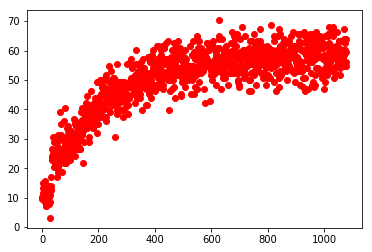

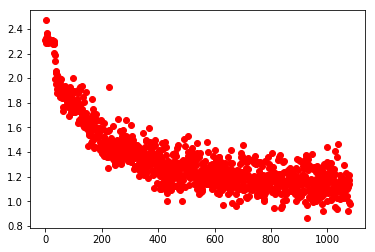

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

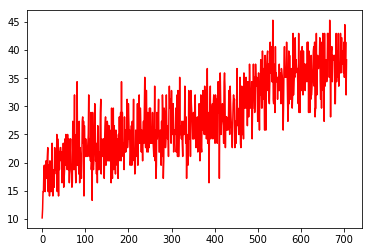

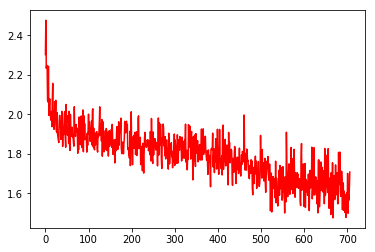

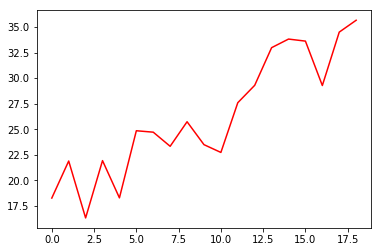

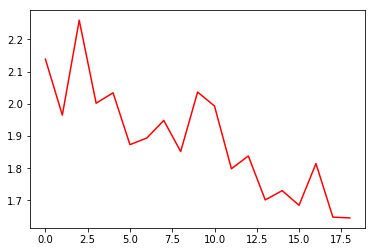

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()